In [1]:
import time

import numpy as np
from scipy.special import softmax

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.data import Dataset
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.train import Checkpoint, CheckpointManager

from sklearn.metrics import accuracy_score, f1_score, classification_report

# Data handler

In [2]:
aspect2id = {
    'ROOM_AMENITIES': 0,
    'SERVICE' : 1,
    'ROOMS' : 2,
    'LOCATION': 3,
    'FOOD&DRINKS' : 4,
    'FACILITIES': 5,
    'HOTEL': 6,
}

In [3]:
def get_vocab(file):
    word2id = {}
    r = open(file, 'r', encoding='utf-8')
    count = 1
    for word in r.read().split('\n'):
        word2id[word] = count
        count += 1
    r.close()
    return word2id

word2id = get_vocab('wordset/hotel_vocab.txt')

In [4]:
num_aspects = len(aspect2id)
vocab_size = len(word2id)

In [5]:
def get_seed(file):
    seed_set = {}
    r = open(file, 'r', encoding='utf-8')
    seeds = r.read().split('\n')[0:-1]
    for i in range(len(seeds)):
        seeds[i] = seeds[i].split('|')[:-1]
        seed_tokens = []
        for seed in seeds[i]:
            if seed in word2id:
                seed_tokens.append(word2id[seed])
            else:
                seed_tokens.append(-1)
        seed_set[i] = seed_tokens
    r.close()
    return seed_set

seed_set = get_seed('wordset/hotel_seeds.txt')

In [6]:
def get_train_inp(file):
    r = open(file, 'r', encoding='utf-8')
    docs = r.readlines()
    inps = []
    for i in range(len(docs)):
        docs[i] = docs[i].split()
        inp = [word2id[word] for word in docs[i]]
        inps.append(inp)
    r.close()
    return inps

train_inp = get_train_inp('processed/hotel_train.txt')

In [7]:
def get_test(file):
    r = open(file, 'r', encoding='utf-8')
    lines = r.readlines()
    inps = []
    outs = []
    for line in lines:
        sent = line.split('|')[0]
        inp = []
        inp = [word2id[word] for word in sent.split() if word in word2id]
        # if len(inp) == 0:
        #     continue
        inps.append(inp)
        
        #print(line)
        aspect = line.split('|')[1][:-1]
        label = aspect2id[aspect]
        out = [0 for i in range(num_aspects)]
        out[label] = 1
        outs.append(out)
    
    r.close()
    return inps, np.array(outs)

dev_inp, dev_out = get_test('processed/hotel_dev.txt')
test_inp, test_out = get_test('processed/hotel_test.txt')

In [8]:
def get_weight_seed(inps, preds, seed_set):
    weight_seed = {}
    for label in seed_set:
        for seed in seed_set[label]:
            weight_seed[seed] = np.zeros(num_aspects)
    
    for i in range(inps.shape[0]):
        for seed in weight_seed:
            if seed in inps[i]:
                weight_seed[seed][preds[i]] += 1

    for label in seed_set:
        for seed in seed_set[label]:
            sum = np.sum(weight_seed[seed])
            if sum != 0:
                weight_seed[seed] /= sum    
    
    return weight_seed

In [9]:
default_weight_seed = {}

for label in seed_set:
    for seed in seed_set[label]:
        default_weight_seed[seed] = np.ones(num_aspects)
        #default_weight_seed[seed] /= np.sum(default_weight_seed[seed]) 

In [10]:
def get_train_weak_out(inps, seed_set, weight_seed=default_weight_seed):
    outs = []
    for inp in inps:
        out = []
        cnt = 0
        for label in seed_set:
            bow = 0
            for seed in seed_set[label]:
                bow += np.count_nonzero(inp == seed) * weight_seed[seed][label]
            if bow == 0:
                cnt += 1
            out.append(bow)
    
        if cnt == len(seed_set):
            out[-1] = 10000000
        outs.append(out)

    outs = softmax(outs, axis=1)
    return outs

# Visualize data

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

<BarContainer object of 81 artists>

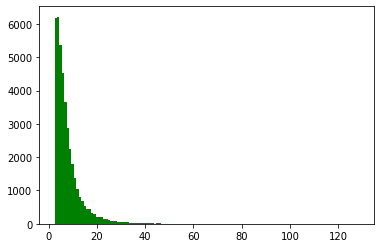

In [12]:
len_train_inp = [len(inp) for inp in train_inp]
len_train_inp = Counter(len_train_inp)
plt.bar(len_train_inp.keys(), len_train_inp.values(), width=1, color='g')

<BarContainer object of 23 artists>

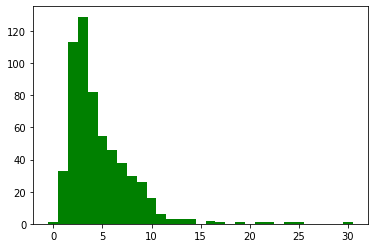

In [13]:
len_test_inp = [len(inp) for inp in test_inp]
len_test_inp = Counter(len_test_inp)
plt.bar(len_test_inp.keys(), len_test_inp.values(), width=1, color='g')

<BarContainer object of 7 artists>

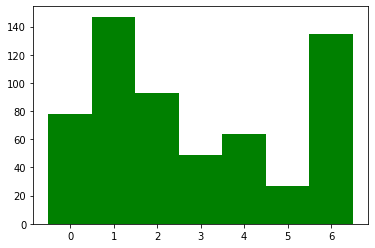

In [14]:
test_label = np.argmax(test_out, axis=1)
len_test_label = Counter(test_label)
plt.bar(len_test_label.keys(), len_test_label.values(), width=1, color='g')

# Create dataset

In [15]:
max_len = 30

train_inp = [inp if len(inp) < max_len else inp[0:max_len] for inp in train_inp]
dev_inp = [inp if len(inp) < max_len else inp[0:max_len] for inp in dev_inp]
test_inp = [inp if len(inp) < max_len else inp[0:max_len] for inp in test_inp]

In [16]:
train_inp = pad_sequences(train_inp, maxlen=max_len)
dev_inp = pad_sequences(dev_inp, maxlen=max_len)
test_inp = pad_sequences(test_inp, maxlen=max_len)

# Define model

In [17]:
class CNNModel(Model):
    def __init__(self, vocab_size, max_len, embedding_dim=300, filters=64, \
        kernel_size=[2,3], pool_size=2, dropout_rate=0.5, hidden_dim=100, output_dim=num_aspects):
        super().__init__(self)

        self.embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)
        
        self.conv1 = Conv1D(filters=filters, kernel_size=kernel_size[0], activation='relu')
        self.conv2 = Conv1D(filters=filters, kernel_size=kernel_size[1], activation='relu')
        
        self.dropout = Dropout(dropout_rate)
        self.maxpool = MaxPool1D(pool_size)
        
        self.flat1 = Flatten()
        self.concat = Concatenate()
        self.hidden = Dense(hidden_dim, activation='relu')

        self.dense = Dense(output_dim, activation='softmax')
    
    def call(self, inputs, training):
        x = inputs
        x = self.embedding(x, training=training)

        x1 = self.conv1(x, training=training)
        x1 = self.maxpool(x1)
        x1 = self.flat1(x1)

        x2 = self.conv2(x, training=training)
        x2 = self.maxpool(x2)
        x2 = self.flat1(x2)

        x = self.concat([x1, x2])
        x = self.dropout(x, training=training)

        x = self.hidden(x, training=training)
        x = self.dense(x, training=training)
        return x

In [18]:
cnn_model = CNNModel(
    vocab_size=vocab_size,
    max_len=max_len)

# Hyper-parameter

In [19]:
loss_function = CategoricalCrossentropy()
accuracy_function = Accuracy()

train_loss = Mean(name='train_loss')
dev_loss = Mean(name='dev_loss')
test_loss = Mean(name='test_loss')

In [20]:
learning_rate = 0.0001

optimizer = Adam(learning_rate=learning_rate)

In [21]:
EPOCHS = 30
ROUNDS = 3
BUFFER_SIZE = 1000
BATCH_SIZE = 128

# Checkpoint

In [22]:
checkpoint_path = "./checkpoints/hotel/"
ckpt = Checkpoint(cnn_model, optimizer=optimizer)
ckpt_manager = CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

In [23]:
@tf.function
def train_step(inp, out):
    with tf.GradientTape() as tape:
        pred = cnn_model(inp, True)

        loss = loss_function(out, pred)
    
    gradients = tape.gradient(loss, cnn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, cnn_model.trainable_variables))

    train_loss(loss)

# Training

In [24]:
def teacher(round, train_inp, dev_inp, dev_out, seed_set):
    print('TEACHER:')
    
    weight_seed = {}

    if round == 0:
        weight_seed = default_weight_seed
    else:
        student_train_pred = cnn_model(train_inp, True)
        student_train_pred = tf.argmax(student_train_pred, axis=1)
        weight_seed = get_weight_seed(train_inp, student_train_pred, seed_set)
    
    dev_pred = get_train_weak_out(dev_inp, seed_set, weight_seed)
    
    dev_acc = accuracy_score(tf.argmax(dev_out, axis=1), tf.argmax(dev_pred, axis=1))

    print(f'Dev Accuracy: {dev_acc:.4f}')
    print()

    return weight_seed

In [25]:
def student(num_epochs, train_inp, dev_inp, dev_out, seed_set, weight_seed):
    print('STUDENT:')
    
    train_out = get_train_weak_out(train_inp, seed_set, weight_seed)

    train_examples = Dataset.from_tensor_slices((train_inp, train_out))

    train_batches = train_examples.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    best_epoch = 0
    best_dev_f1 = 0

    for epoch in range(num_epochs):
        start = time.time()

        train_loss.reset_states()

        for (batch, (inp, out)) in enumerate(train_batches):
            train_step(inp, out)
            if batch % 200 == 0:
                print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f}')

        dev_loss.reset_states()

        dev_inp_tensor = tf.constant(dev_inp)
        dev_out_tensor = tf.constant(dev_out)

        dev_pred = cnn_model(dev_inp_tensor, True)
        loss = loss_function(dev_out_tensor, dev_pred)
        dev_f1 = f1_score(tf.argmax(dev_out_tensor, axis=1), tf.argmax(dev_pred, axis=1), average='macro')

        if dev_f1 > best_dev_f1:
            best_dev_f1 = dev_f1
            best_epoch = epoch
        
        dev_loss(loss)

        if (epoch + 1) % 1 == 0:
            ckpt_save_path = ckpt_manager.save()
            print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
        
        print(f'Epoch {epoch + 1}: Loss {train_loss.result():.4f}')
    
        print(f'Dev loss: {dev_loss.result():.4f} Dev F1 Score: {dev_f1:.4f}')
    
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

    return best_epoch


In [26]:
epoch = 0

In [27]:
for round in range(ROUNDS):

    print(f'ROUND {round + 1}:')
    
    # TEACHER
    weight_seed = teacher(round, train_inp, dev_inp, dev_out, seed_set)
        
    # STUDENT
    best_epoch = student(EPOCHS, train_inp, dev_inp, dev_out, seed_set, weight_seed) + 1
    epoch = epoch + best_epoch

    # Restore best epoch
    ckpt.restore(checkpoint_path + 'ckpt-' + str(epoch))
    print(f'Restore best epoch\n')

    # Teacher's result
    teacher_test_pred = get_train_weak_out(test_inp, seed_set, weight_seed)
    teacher_f1 = f1_score(tf.argmax(test_out, axis=1), tf.argmax(teacher_test_pred, axis=1), average='macro')
    tch_clfrpt = classification_report(tf.argmax(test_out, axis=1), tf.argmax(teacher_test_pred, axis=1))

    print('TEACHER:')
    print(f'Test F1 Score: {teacher_f1:.4f}\n')
    print(tch_clfrpt)

    # Student's result
    test_inp_tensor = tf.constant(test_inp)
    test_out_tensor = tf.constant(test_out)
    
    student_test_pred = cnn_model(test_inp_tensor, True)
    student_f1 = f1_score(tf.argmax(test_out_tensor, axis=1), tf.argmax(student_test_pred, axis=1), average='macro')
    std_clfrpt = classification_report(tf.argmax(test_out_tensor, axis=1), tf.argmax(student_test_pred, axis=1))

    print('STUDENT:')
    print(f'Test F1 Score: {student_f1:.4f}\n')
    print(std_clfrpt)

ROUND 1:
TEACHER:
Dev Accuracy: 0.8203

STUDENT:
Epoch 1 Batch 0 Loss 1.9410
Epoch 1 Batch 200 Loss 1.8624
Saving checkpoint for epoch 1 at ./checkpoints/hotel/ckpt-1
Epoch 1: Loss 1.7976
Dev loss: 1.4608 Dev F1 Score: 0.3475
Time taken for 1 epoch: 12.81 secs

Epoch 2 Batch 0 Loss 1.6523
Epoch 2 Batch 200 Loss 1.5817
Saving checkpoint for epoch 2 at ./checkpoints/hotel/ckpt-2
Epoch 2: Loss 1.5540
Dev loss: 1.1475 Dev F1 Score: 0.5651
Time taken for 1 epoch: 11.69 secs

Epoch 3 Batch 0 Loss 1.4483
Epoch 3 Batch 200 Loss 1.4962
Saving checkpoint for epoch 3 at ./checkpoints/hotel/ckpt-3
Epoch 3: Loss 1.4806
Dev loss: 1.0439 Dev F1 Score: 0.6655
Time taken for 1 epoch: 13.64 secs

Epoch 4 Batch 0 Loss 1.4179
Epoch 4 Batch 200 Loss 1.4622
Saving checkpoint for epoch 4 at ./checkpoints/hotel/ckpt-4
Epoch 4: Loss 1.4497
Dev loss: 1.0012 Dev F1 Score: 0.7046
Time taken for 1 epoch: 13.76 secs

Epoch 5 Batch 0 Loss 1.4276
Epoch 5 Batch 200 Loss 1.4423
Saving checkpoint for epoch 5 at ./checkp